In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns

random.seed(1220)

This script will generate example decision-making data on a very simple college admissions process, consisting of three groups with equivalent distributions in innate TestingAbility to graduate college. However, some groups have a higher likelihood of receiving application assistance in the form of test prep. Each applicant gets an entrance test score, which we assume to be a function of their individual graduation likelihood plus some constant boost if they've recieved test prep. Thus, admissions teams using test scores to predict a student's likelihood of graduation are somewhat misled by this test prep effect.

In [2]:
sim_params =  {'POP_SIZE' : 50000,
              'POP_RATIO' : [1/5, 1/5],
              'GROUPS' : ['A', 'B'],
              'HSI_VALUE_ADDED_MEAN' : {1 : 50, 
                                       0 : 0},
              'HSI_VALUE_ADDED_SD' : {1 : 5, 
                                     0 : 5},                        
              'GROUP_HSI' : {'A': .8, 
                            'B': .2},
              'TRUE_RATING_MEAN' : 100,
              'TRUE_RATING_SD' : 20,
              'TESTING_ABILITY_SD' : 25}

def sim_admissions_data(POP_SIZE, POP_RATIO, GROUPS, HSI_VALUE_ADDED_MEAN, HSI_VALUE_ADDED_SD,
                        GROUP_HSI, TRUE_RATING_MEAN, TRUE_RATING_SD, TESTING_ABILITY_SD):
# simulate population consisting of given size and distribution, with a 'true' rating for each student,
# as well as factors that correlate strongly with their true rating
    sim_admission = pd.DataFrame(
        {'Group' : random.choices(GROUPS, weights=POP_RATIO, k = POP_SIZE),
        'BaseAbility': [int(random.gauss(
            TRUE_RATING_MEAN, TRUE_RATING_SD)) for _ in range(POP_SIZE)]})

    ##NOTE this would be more realistic if we call HSValueAdded something harder to observe that 
    ##is disproportionate across groups

    # assign each individual to a high school depending on their likelihood of going to High School Indigo
    sim_admission.loc[:, 'HighSchool_Indigo'] = sim_admission.loc[:, 'Group']\
        .apply(lambda grp: random.choices([1,0], cum_weights=[GROUP_HSI[grp], 1])[0])
    
    # assign each individual a 'value added' from their school's quality
    # (this is assumed to be normally distributed as per fixed effects modelling value added literature)
    sim_admission.loc[:, 'HSValueAdded'] = sim_admission.loc[:, 'HighSchool_Indigo']\
        .apply(lambda hsi: int(random.gauss(HSI_VALUE_ADDED_MEAN[hsi], HSI_VALUE_ADDED_SD[hsi])))

    # #Assign each individual a GPA relative to the difficulty/rigor of their school
    # sim_admission.loc[:,'GPA'] = \
    #     (sim_admission.loc[:,'BaseAbility'] - \
    #         (TRUE_RATING_MEAN + 
    #         (sim_admission.loc[:,'HighSchool_Indigo'] * HSI_VALUE_ADDED_MEAN[1]) - \
    #         ((1 - sim_admission.loc[:,'HighSchool_Indigo']) * HSI_VALUE_ADDED_MEAN[0]))) / (TRUE_RATING_MEAN + sim_admission.loc[:,'HighSchool_Indigo'] * HSI_VALUE_ADDED_MEAN[1]) + 4.0
            
            # (TRUE_RATING_MEAN + 2*TRUE_RATING_SD + 
            # (sim_admission.loc[:,'HighSchool_Indigo'] * (HSI_VALUE_ADDED_MEAN[1] + 2*HSI_VALUE_ADDED_SD[1])) + 
            # ((1 - sim_admission.loc[:,'HighSchool_Indigo']) * (HSI_VALUE_ADDED_MEAN[0] + 2*HSI_VALUE_ADDED_SD[0]))) * 4.0
    # sim_admission.loc[:,'GPA'] = sim_admission.loc[:,'GPA'].apply(lambda x: min(x, 4.0))

    # assign each individual a 'test ability' (this will encompass the error term in
    # our later regression and is unobserved)
    sim_admission.loc[:, 'TestingAbility'] = [int(random.gauss(0, TESTING_ABILITY_SD)) for _ in range(POP_SIZE)]

    # assign a test score as a function of their actual grad chance, any test prep, and some noise
    sim_admission.loc[:, 'TestScore'] = \
        (sim_admission.loc[:, 'BaseAbility'] + 
        sim_admission.loc[:, 'HSValueAdded'] / 2 +
        sim_admission.loc[:, 'TestingAbility'])
    
    return sim_admission

In [3]:
sim_admission = sim_admissions_data(**sim_params)
sim_admission.head(20)

,Group,BaseAbility,HighSchool_Indigo,HSValueAdded,TestingAbility,TestScore
0,A,109,1,45,-12,119.5
1,B,84,0,0,3,87.0
2,A,84,1,48,-16,92.0
3,A,63,1,45,27,112.5
4,B,94,0,-3,28,120.5
5,B,115,1,53,-29,112.5
6,A,128,1,43,6,155.5
7,B,115,0,5,26,143.5
8,B,85,0,-8,11,92.0
9,B,61,1,43,15,97.5


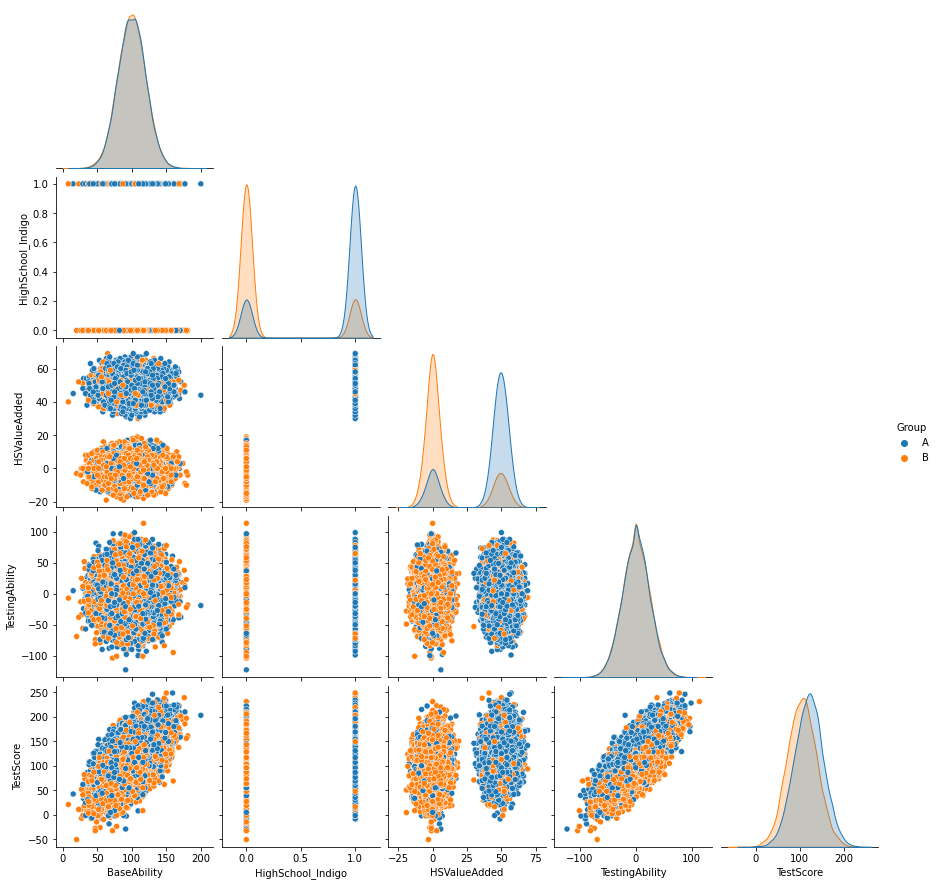

In [4]:
sns.pairplot(sim_admission, hue = 'Group', corner = True)
# sns.scatterplot(data = sim_admission, x = 'BaseAbility', y = 'GPA', hue = 'HighSchool_Indigo')

<AxesSubplot:xlabel='Group', ylabel='BaseAbility'>

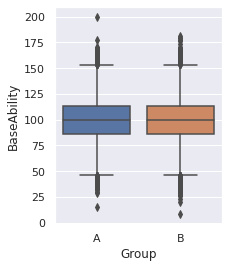

In [5]:
sns.set(rc={"figure.figsize":(3, 4)}) 
sns.boxplot(data = sim_admission, x = 'Group', y = 'BaseAbility', order=sim_params['GROUPS'])

<AxesSubplot:xlabel='Group', ylabel='TestScore'>

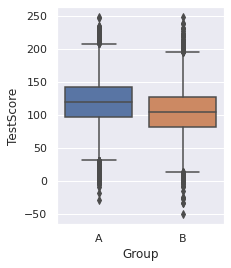

In [6]:
sns.boxplot(data = sim_admission, x = 'Group', y = 'TestScore', order=sim_params['GROUPS'])

<AxesSubplot:xlabel='BaseAbility', ylabel='TestScore'>

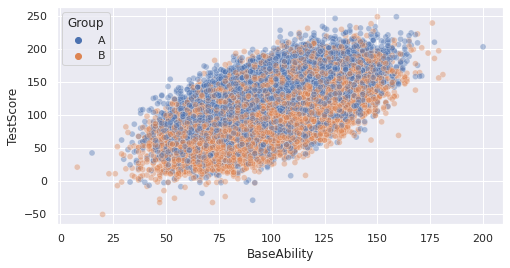

In [7]:
sns.set(rc={"figure.figsize":(8, 4)}) 
sns.scatterplot(data = sim_admission, x = 'BaseAbility', y = 'TestScore', hue='Group', alpha = .4)

As we can see from these distributions, the _only_ thing that varies across groups is likelihood of receiving test prep. In kind, the group that is most likely to recieve test prep is most likely to recieve a high score on an entry test. Now, if admissions chooses to consider only test scores and decides to admit the top 20% of the population of applicants:

In [8]:
def naiive_cutoff(sim_admission):
    test_norm = (sim_admission['TestScore'] - np.mean(sim_admission['TestScore'])) / np.std(sim_admission['TestScore'])
    decision_cutoff = np.quantile(test_norm, q = .8)
    sim_admission.loc[:,'Admitted'] = (test_norm >= decision_cutoff).apply(int)
    return sim_admission

In [9]:
sim_admission = naiive_cutoff(sim_admission)

Now, we need to simulate which students succeed in graduating. To do so, I will map ratings to a logistic function: $$ \frac{1}{1+e^{\frac{x}{10} - 11}} $$ where x is the `BaseAbility` for a student.

In [10]:
sim_admission

,Group,BaseAbility,HighSchool_Indigo,HSValueAdded,TestingAbility,TestScore,Admitted
0,A,109,1,45,-12,119.5,0
1,B,84,0,0,3,87.0,0
2,A,84,1,48,-16,92.0,0
3,A,63,1,45,27,112.5,0
4,B,94,0,-3,28,120.5,0
...,...,...,...,...,...,...,...
49995,A,71,1,50,0,96.0,0
49996,A,116,1,46,-32,107.0,0
49997,B,98,0,1,-25,73.5,0
49998,A,110,1,54,-20,117.0,0


In [11]:
def calc_grad_prob(sim_admission, noise = 3):
    import math
    sim_admission.loc[:,'p_Graduation'] = sim_admission.apply(
        lambda row: 1/(1+ math.e**(-.05*(
            (row['BaseAbility'] + row['HSValueAdded']) - 145 + \
            int(random.gauss(0, noise))))), axis=1)
    return sim_admission
sim_admission = calc_grad_prob(sim_admission)

<AxesSubplot:xlabel='BaseAbility', ylabel='p_Graduation'>

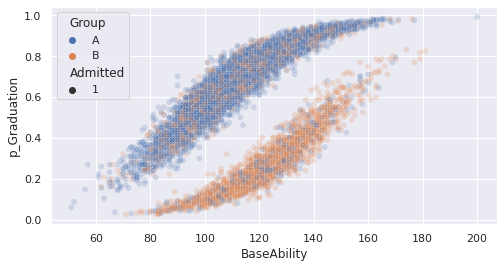

In [12]:
admitted_mask = sim_admission['Admitted'] == 1

sns.scatterplot(data = sim_admission[admitted_mask], x = 'BaseAbility', y = 'p_Graduation', hue= 'Group', style= 'Admitted', alpha = .2)

<AxesSubplot:xlabel='BaseAbility', ylabel='p_Graduation'>

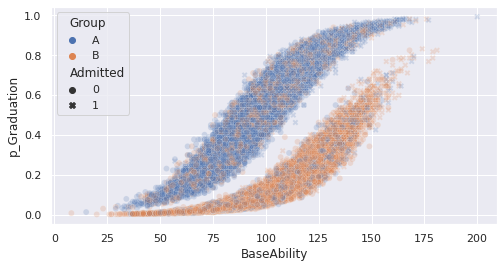

In [13]:
sns.scatterplot(data = sim_admission, x = 'BaseAbility', y = 'p_Graduation', hue= 'Group', style= 'Admitted', alpha = .2)

And now, flip the (weighted) coin for each student according to their probTestingAbility of graduating to get their actual graduation outcome.

In [14]:
def sim_graduation(admissions_data):
    admissions_data.loc[:,'Actual_Graduation'] = \
        admissions_data.loc[:,'p_Graduation'].apply(
            lambda x: random.choices([1,0], cum_weights=[x, 1])[0])
    # admissions_data.loc[:,'Actual_Graduation'] = np.select([admissions_data['Admitted'] == 1],[admissions_data['Actual_Graduation']], default = np.nan)
    return admissions_data
sim_admission = sim_graduation(sim_admission)

In [15]:
sim_admission[sim_admission['Admitted'] == 1].groupby('Group')['p_Graduation'].mean()

Group
A    0.659003
B    0.451850
Name: p_Graduation, dtype: float64

In [16]:
sim_admission[sim_admission['Admitted'] == 1].groupby('Group')['Actual_Graduation'].mean()

Group
A    0.653711
B    0.452348
Name: Actual_Graduation, dtype: float64

In [17]:
sim_admission.groupby('Group')['p_Graduation'].mean()

Group
A    0.458529
B    0.210539
Name: p_Graduation, dtype: float64

In [18]:
sim_admission.groupby('Group')['Actual_Graduation'].mean()

Group
A    0.455790
B    0.207973
Name: Actual_Graduation, dtype: float64

In [19]:
#NOTE group only kept in here for the purpose of stratified k-fold - it will not be used as a predictor
# X = sim_admission[admitted_mask].loc[:,['Group', 'HighSchool_Indigo', 'TestScore']]
# Y = sim_admission[admitted_mask].loc[:,'Actual_Graduation']
X = sim_admission.loc[:,['Group', 'HighSchool_Indigo', 'TestScore']]
Y = sim_admission.loc[:,'Actual_Graduation']
X.shape, Y.shape

((50000, 3), (50000,))

In [20]:
from sklearn import linear_model
from sklearn import model_selection

best_acc = 0
skf = model_selection.StratifiedKFold(n_splits = 10)
# stratified k-fold will split to ensure balance on categorical groups - in our case,
# the group variable. 

for idx, (train_index, test_index) in enumerate(skf.split(X, Y)):
    #split into train and test, drop group as a variable for prediction
    x_train_fold = X.iloc[train_index,:].loc[:,['TestScore', 'HighSchool_Indigo']]
    y_train_fold = Y.iloc[train_index]
    x_test_fold = X.iloc[test_index,:].loc[:,['TestScore', 'HighSchool_Indigo']]
    y_test_fold = Y.iloc[test_index]

    RatingPrediction = linear_model.LogisticRegression()

    #get data 
    RatingPrediction.fit(x_train_fold, y_train_fold)
    predicted_graduation = RatingPrediction.predict(x_test_fold)
    acc = np.mean(predicted_graduation == y_test_fold) # average number of correct predictions
    if acc > best_acc:
        best_acc = acc
        best_model = RatingPrediction

Now, using our best model from the stratified cross-validation, we have a model that predicts graduation correctly about 70% of the time.

In [21]:
best_acc

0.7558

In [22]:
sim_params['POP_SIZE'] = 100000
sim_params['HSI_VALUE_ADDED_MEAN']= {1: 50, 
                                     0: 50}
# sim_params['GROUP_HSI'] = {'A': .5, 
#                           'B': .5}
new_sim_admission = sim_admissions_data(**sim_params)

Let's generate some out of sample data (new data) and use this model to make predictions about how these new students will do.

In [23]:
new_sim_admission = calc_grad_prob(new_sim_admission)
new_sim_admission.loc[:,'Predicted_Graduation'] = best_model.predict(new_sim_admission.loc[:,['TestScore', 'HighSchool_Indigo']])
new_sim_admission.loc[:,'Predicted_p_Graduation'] = best_model.predict_proba(new_sim_admission.loc[:,['TestScore', 'HighSchool_Indigo']])[:,1]

In [24]:
sim_admission.loc[:,'Predicted_Graduation'] = best_model.predict(sim_admission.loc[:,['TestScore', 'HighSchool_Indigo']])
sim_admission.loc[:,'Predicted_p_Graduation'] = best_model.predict_proba(sim_admission.loc[:,['TestScore', 'HighSchool_Indigo']])[:,1]

<AxesSubplot:xlabel='Group', ylabel='Predicted_p_Graduation'>

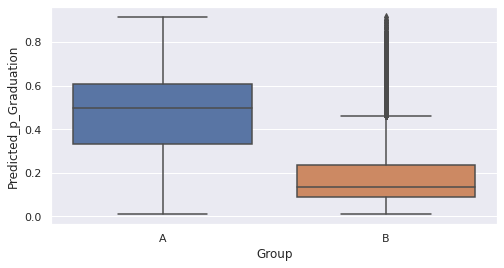

In [25]:
sns.boxplot(data = sim_admission, x = 'Group', y = 'Predicted_p_Graduation', order = ['A','B'])

<AxesSubplot:xlabel='Predicted_p_Graduation', ylabel='p_Graduation'>

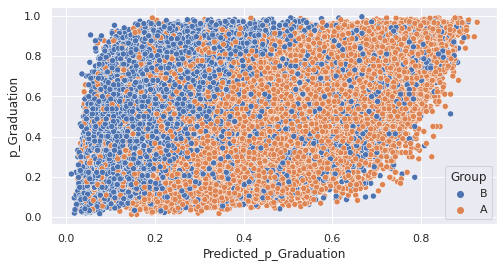

In [26]:
sns.scatterplot(data = new_sim_admission, x = 'Predicted_p_Graduation', y = 'p_Graduation', hue = 'Group')

In [27]:
#make admissions based on predicted graduation
def model_cutoff(sim_admission, model):
    sim_admission.loc[:,'Predicted_Graduation'] = model.predict(sim_admission.loc[:,['TestScore', 'HighSchool_Indigo']])
    sim_admission.loc[:,'Predicted_p_Graduation'] = model.predict_proba(sim_admission.loc[:,['TestScore', 'HighSchool_Indigo']])[:,1]

    decision_cutoff = np.quantile(sim_admission.loc[:,'Predicted_p_Graduation'], q = .8)
    sim_admission.loc[:,'Admitted'] = (sim_admission.loc[:,'Predicted_p_Graduation'] >= decision_cutoff).apply(int)
    return sim_admission
    
new_sim_admission = model_cutoff(new_sim_admission, best_model)
new_sim_admission = sim_graduation(new_sim_admission)

<AxesSubplot:xlabel='Predicted_p_Graduation', ylabel='p_Graduation'>

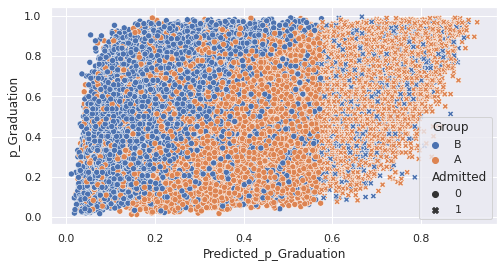

In [28]:
sns.scatterplot(data = new_sim_admission, x = 'Predicted_p_Graduation', y = 'p_Graduation', hue = 'Group', style= 'Admitted')

In [29]:
new_sim_admission[new_sim_admission['Admitted'] == 1]

,Group,BaseAbility,HighSchool_Indigo,HSValueAdded,TestingAbility,TestScore,p_Graduation,Predicted_Graduation,Predicted_p_Graduation,Admitted,Actual_Graduation
3,B,113,1,46,6,142.0,0.668188,1,0.616941,1,0
4,B,142,1,49,-29,137.5,0.895669,1,0.597586,1,1
5,A,121,1,51,30,176.5,0.740775,1,0.750047,1,1
8,A,110,1,55,13,150.5,0.731059,1,0.652467,1,1
12,A,118,1,49,55,197.5,0.721115,1,0.814216,1,1
...,...,...,...,...,...,...,...,...,...,...,...
99968,A,101,1,52,18,145.0,0.610639,1,0.629645,1,1
99983,B,123,1,53,-6,143.5,0.832018,1,0.623314,1,1
99987,A,103,1,50,11,139.0,0.574443,1,0.604075,1,0
99993,A,104,1,57,22,154.5,0.731059,1,0.668641,1,1


<AxesSubplot:xlabel='Predicted_p_Graduation', ylabel='Count'>

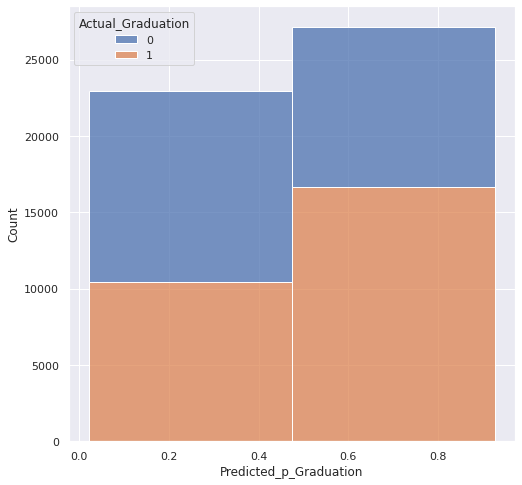

In [35]:
sns.histplot(data = new_sim_admission[(new_sim_admission['Group'] == 'A')],
            x = 'Predicted_p_Graduation', hue = 'Actual_Graduation', multiple='stack', bins = 2)

<AxesSubplot:xlabel='Predicted_p_Graduation', ylabel='Count'>

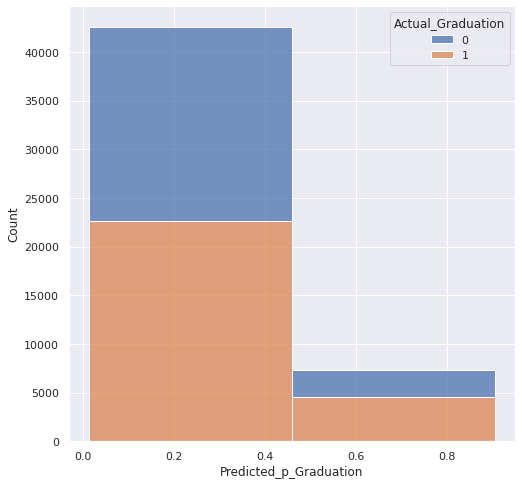

In [34]:
sns.histplot(data = new_sim_admission[(new_sim_admission['Group'] == 'B')],
            x = 'Predicted_p_Graduation', hue = 'Actual_Graduation', multiple='stack', bins = 2)

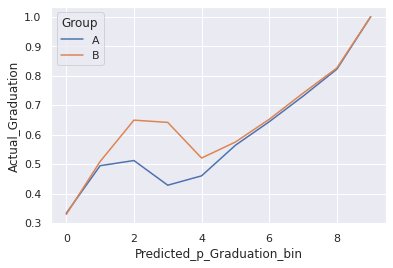

In [36]:
new_sim_admission.loc[:,'Predicted_p_Graduation_bin'] = \
    pd.cut(new_sim_admission.loc[:,'Predicted_p_Graduation'], bins = np.arange(0,1,.1)+.1).factorize(sort = True)[0] + 1
lineplot_admin = new_sim_admission.groupby(['Predicted_p_Graduation_bin', 'Group'])['Actual_Graduation'].apply(np.mean).reset_index()

sns.set(rc={"figure.figsize":(8, 8)}) 
fig, ax = plt.subplots(figsize=(6, 4))

p1 = sns.lineplot(data = lineplot_admin,
            x = 'Predicted_p_Graduation_bin',
            y = 'Actual_Graduation',
            hue = 'Group')
# p2 = sns.lineplot(x = [.5,10.5], y = [0,1])
plt.show()

In [33]:
pd.cut(new_sim_admission.loc[:,'Predicted_p_Graduation'], bins = np.arange(0,1,.1)+.1).factorize(sort = True)[0]

array([-1,  2,  2, ...,  6,  0,  4])